# Loading repository and dataset

In [1]:
# If you want to update repository (re-download)
!rm -r DeepImageInpainting

rm: cannot remove 'DeepImageInpainting': No such file or directory


In [2]:
!git clone https://github.com/Nagim123/DeepImageInpainting.git

Cloning into 'DeepImageInpainting'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 415 (delta 80), reused 105 (delta 43), pack-reused 267
Receiving objects: 100% (415/415), 47.68 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [3]:
!python DeepImageInpainting/src/data/create_dataset_stl_10.py

Выходные данные были обрезаны до нескольких последних строк (5000).
Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  46% 1167/2518 [01:18<01:23, 16.12 MiB/s]

Extraction completed...: 0 file [01:18, ? file/s]
Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  46% 1168/2518 [01:18<01:21, 16.65 MiB/s]

Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  46% 1169/2518 [01:18<01:21, 16.65 MiB/s]

Extraction completed...: 0 file [01:18, ? file/s]
Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  46% 1170/2518 [01:18<01:27, 15.44 MiB/s]

Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  47% 1171/2518 [01:18<01:27, 15.44 MiB/s]

Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  47% 1172/2518 [01:18<01:27, 15.44 MiB/s]

Extraction completed...: 0 file [01:18, ? file/s]
Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  47% 1173/2518 [01:18<01:23, 16.04 MiB/s]

Dl Completed...:   0% 0/1 [01:18<?, ? url/s]
Dl Size...:  47% 1174/2518 [01:18<01:

In [4]:
!python DeepImageInpainting/src/data/show_image.py stl10.pt

Saved to temp/temp.png!


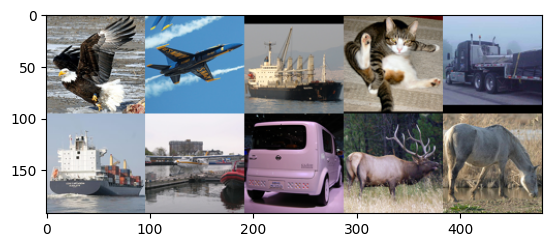

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))

In [6]:
!python DeepImageInpainting/src/data/show_image.py stl10.pt --masked

Saved to temp/temp.png!


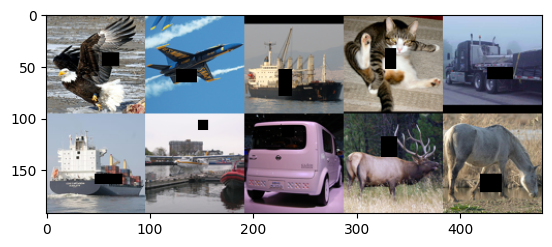

In [7]:
plt.imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))

# Model

In [8]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # todo
        # Hint: Do not use ReLU in last convolutional set of up-path (128-64-64) for stability reasons!
        self.downStep1 = downStep(3, 64, firstLayer=True)
        self.downStep2 = downStep(64, 128)
        self.downStep3 = downStep(128, 256)
        self.downStep4 = downStep(256, 512)
        self.downStep5 = downStep(512, 1024)

        self.upStep1 = upStep(1024, 512)
        self.upStep2 = upStep(512, 256)
        self.upStep3 = upStep(256, 128)
        self.upStep4 = upStep(128, 64)

        self.conv = nn.Conv2d(64, 3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # todo
        x1 = self.downStep1(x)
        # print('x1', x1.shape)
        x2 = self.downStep2(x1)
        # print('x2', x2.shape)
        x3 = self.downStep3(x2)
        # print('x3', x3.shape)
        x4 = self.downStep4(x3)
        # print('x4', x4.shape)
        x5 = self.downStep5(x4)
        # print('x5', x5.shape)

        x = self.upStep1(x5, x4)
        # print(x.shape)
        x = self.upStep2(x, x3)
        # print(x.shape)
        x = self.upStep3(x, x2)
        # print(x.shape)
        x = self.upStep4(x, x1)
        # print(x.shape)

        x = self.conv(x)
        # print(x.shape)
        x = self.sigmoid(x)

        return x

class downStep(nn.Module):
    def __init__(self, inC, outC, firstLayer=False):
        super(downStep, self).__init__()
        # todo
        self.firstLayer = firstLayer

        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        # todo
        if not self.firstLayer:
            x = self.maxpool(x)

        x = self.conv(x)

        return x

class upStep(nn.Module):
    def __init__(self, inC, outC):
        super(upStep, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inC, outC, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(outC, outC, 3, padding=1),
            nn.ReLU())

        self.upsampling = nn.ConvTranspose2d(inC, outC, 2, 2)

    def forward(self, x, x_down):
        # todo
        x = self.upsampling(x)

        x = torch.cat([x_down, x], dim=1)

        x = self.conv(x)

        return x

In [9]:
model = UNet()
model_scripted = torch.jit.script(model)
model_scripted.save("unet.pt")

In [13]:
!python DeepImageInpainting/src/train_model.py unet.pt stl10.pt 20 BCELoss

Epoch: 0
100% 110/110 [00:23<00:00,  4.64it/s, loss=0.579]
100% 47/47 [00:03<00:00, 13.80it/s, e_loss=0.582]
Average train loss:0.64657994129441 
 Average validation loss:0.5889156067625005
Epoch: 1
100% 110/110 [00:22<00:00,  4.93it/s, loss=0.521]
100% 47/47 [00:03<00:00, 13.58it/s, e_loss=0.543]
Average train loss:0.5557977134531195 
 Average validation loss:0.5443739269642119
Epoch: 2
100% 110/110 [00:22<00:00,  4.83it/s, loss=0.509]
100% 47/47 [00:03<00:00, 13.30it/s, e_loss=0.546]
Average train loss:0.5372905522584915 
 Average validation loss:0.5337935159815118
Epoch: 3
100% 110/110 [00:23<00:00,  4.74it/s, loss=0.509]
100% 47/47 [00:03<00:00, 13.00it/s, e_loss=0.521]
Average train loss:0.5313195938413794 
 Average validation loss:0.5308185245128388
Epoch: 4
100% 110/110 [00:23<00:00,  4.71it/s, loss=0.506]
100% 47/47 [00:03<00:00, 13.12it/s, e_loss=0.532]
Average train loss:0.5291909616101872 
 Average validation loss:0.529629832886635
Epoch: 5
100% 110/110 [00:23<00:00,  4.75it

# Test

## On seen data

In [14]:
!python DeepImageInpainting/src/predict_model.py unet.pt DeepImageInpainting/src/models/best_weights.pt --dataset stl10.pt --image_index 0
!python DeepImageInpainting/src/data/show_image.py stl10.pt --image_index 0 --masked

Saved to temp/temp.png!


<Figure size 640x480 with 0 Axes>

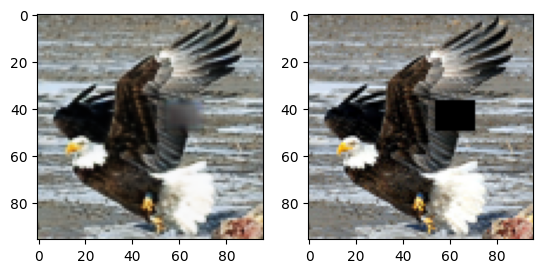

In [15]:
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].imshow(Image.open('prediction.png'))
axarr[1].imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))